# Example 16: Logic Trees for Uncertainty Quantification

This example demonstrates the use of LogicTree functionality in PyStrata for managing epistemic uncertainties in seismic site response analysis. Logic trees provide a structured approach to represent alternative models, parameters, and their associated weights.

**Key concepts covered:**
- Creating logic tree nodes with alternatives
- Setting conditional dependencies between parameters
- Generating valid branches and calculating weights
- Using logic trees with site response calculations
- Visualizing uncertainty propagation

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pystrata
from pystrata.logic_tree import Alternative, LogicTree, Node

%matplotlib inline
plt.rcParams["figure.dpi"] = 120

## 1. Basic Logic Tree Concepts

A logic tree consists of **nodes** that represent uncertain parameters. Each node contains **alternatives** with associated weights and optional conditional dependencies.

In [ ]:
# Create a simple logic tree with three parameters
simple_tree = LogicTree(
    [
        # Site classification with equal weights
        Node(
            "site_class", [Alternative("C", weight=0.4), Alternative("D", weight=0.6)]
        ),
        # Shear wave velocity uncertainty
        Node(
            "vs_factor",
            [
                Alternative(0.8, weight=0.2),  # Lower bound
                Alternative(1.0, weight=0.6),  # Best estimate
                Alternative(1.2, weight=0.2),  # Upper bound
            ],
        ),
        # Damping model choice
        Node(
            "damping_model",
            [
                Alternative("darendeli", weight=0.7),
                Alternative("seed_idriss", weight=0.3),
            ],
        ),
    ]
)

print(f"Logic tree has {len(list(simple_tree))} valid branches")

# Display first few branches
for i, branch in enumerate(simple_tree):
    if i < 5:
        print(f"Branch {i + 1}: {branch.as_dict()}, weight: {branch.weight:.3f}")

Logic tree has 12 valid branches
Branch 1: {'site_class': 'C', 'vs_factor': 0.8, 'damping_model': 'darendeli'}, weight: 0.056
Branch 2: {'site_class': 'C', 'vs_factor': 0.8, 'damping_model': 'seed_idriss'}, weight: 0.024
Branch 3: {'site_class': 'C', 'vs_factor': 1.0, 'damping_model': 'darendeli'}, weight: 0.168
Branch 4: {'site_class': 'C', 'vs_factor': 1.0, 'damping_model': 'seed_idriss'}, weight: 0.072
Branch 5: {'site_class': 'C', 'vs_factor': 1.2, 'damping_model': 'darendeli'}, weight: 0.056


## 2. Conditional Dependencies

Logic trees can include conditional dependencies where certain alternatives are only valid given specific conditions.

In [ ]:
# Create a logic tree with conditional dependencies
conditional_tree = LogicTree(
    [
        # Soil type classification
        Node(
            "soil_type",
            [Alternative("clay", weight=0.4), Alternative("sand", weight=0.6)],
        ),
        # Plasticity index (only relevant for clay)
        Node(
            "plasticity_index",
            [
                Alternative("low", weight=0.3, requires={"soil_type": "clay"}),
                Alternative("medium", weight=0.4, requires={"soil_type": "clay"}),
                Alternative("high", weight=0.3, requires={"soil_type": "clay"}),
                Alternative(
                    "not_applicable", weight=1.0, requires={"soil_type": "sand"}
                ),
            ],
        ),
        # Relative density (only relevant for sand)
        Node(
            "relative_density",
            [
                Alternative("loose", weight=0.2, requires={"soil_type": "sand"}),
                Alternative("medium", weight=0.6, requires={"soil_type": "sand"}),
                Alternative("dense", weight=0.2, requires={"soil_type": "sand"}),
                Alternative(
                    "not_applicable", weight=1.0, requires={"soil_type": "clay"}
                ),
            ],
        ),
        # Nonlinear model selection with exclusions
        Node(
            "nonlinear_model",
            [
                Alternative("hyperbolic", weight=0.5),
                Alternative(
                    "gq_h", weight=0.3, excludes={"soil_type": "clay"}
                ),  # Only for sand
                Alternative(
                    "pressurized", weight=0.2, requires={"soil_type": "clay"}
                ),  # Only for clay
            ],
        ),
    ]
)

print(f"Conditional tree has {len(list(conditional_tree))} valid branches")
print("\nValid branches:")
for i, branch in enumerate(conditional_tree):
    print(f"{i + 1:2d}: {branch.as_dict()}, weight: {branch.weight:.3f}")

Conditional tree has 12 valid branches

Valid branches:
 1: {'soil_type': 'clay', 'plasticity_index': 'low', 'relative_density': 'not_applicable', 'nonlinear_model': 'hyperbolic'}, weight: 0.060
 2: {'soil_type': 'clay', 'plasticity_index': 'low', 'relative_density': 'not_applicable', 'nonlinear_model': 'pressurized'}, weight: 0.024
 3: {'soil_type': 'clay', 'plasticity_index': 'medium', 'relative_density': 'not_applicable', 'nonlinear_model': 'hyperbolic'}, weight: 0.080
 4: {'soil_type': 'clay', 'plasticity_index': 'medium', 'relative_density': 'not_applicable', 'nonlinear_model': 'pressurized'}, weight: 0.032
 5: {'soil_type': 'clay', 'plasticity_index': 'high', 'relative_density': 'not_applicable', 'nonlinear_model': 'hyperbolic'}, weight: 0.060
 6: {'soil_type': 'clay', 'plasticity_index': 'high', 'relative_density': 'not_applicable', 'nonlinear_model': 'pressurized'}, weight: 0.024
 7: {'soil_type': 'sand', 'plasticity_index': 'not_applicable', 'relative_density': 'loose', 'nonli

## 3. Weight Analysis and Statistics

Analyze the distribution of weights across branches and parameters.

In [ ]:
# Collect branch data for analysis
branches_data = []
for branch in conditional_tree:
    branch_dict = branch.as_dict()
    branch_dict["weight"] = branch.weight
    branches_data.append(branch_dict)

df = pd.DataFrame(branches_data)
print("Branch statistics:")
print(df.describe())

# Verify weights sum to 1
total_weight = df["weight"].sum()
print(f"\nTotal weight: {total_weight:.6f}")

# Marginal probabilities for each parameter
print("\nMarginal probabilities:")
for param in ["soil_type", "plasticity_index", "relative_density", "nonlinear_model"]:
    marginal = df.groupby(param)["weight"].sum().sort_values(ascending=False)
    print(f"\n{param}:")
    for value, weight in marginal.items():
        print(f"  {value}: {weight:.3f}")

Branch statistics:
          weight
count  12.000000
mean    0.063333
std     0.044209
min     0.024000
25%     0.035000
50%     0.060000
75%     0.065000
max     0.180000

Total weight: 0.760000

Marginal probabilities:

soil_type:
  sand: 0.480
  clay: 0.280

plasticity_index:
  not_applicable: 0.480
  medium: 0.112
  low: 0.084
  high: 0.084

relative_density:
  medium: 0.288
  not_applicable: 0.280
  loose: 0.096
  dense: 0.096

nonlinear_model:
  hyperbolic: 0.500
  gq_h: 0.180
  pressurized: 0.080


## 4. Visualization of Logic Tree Structure

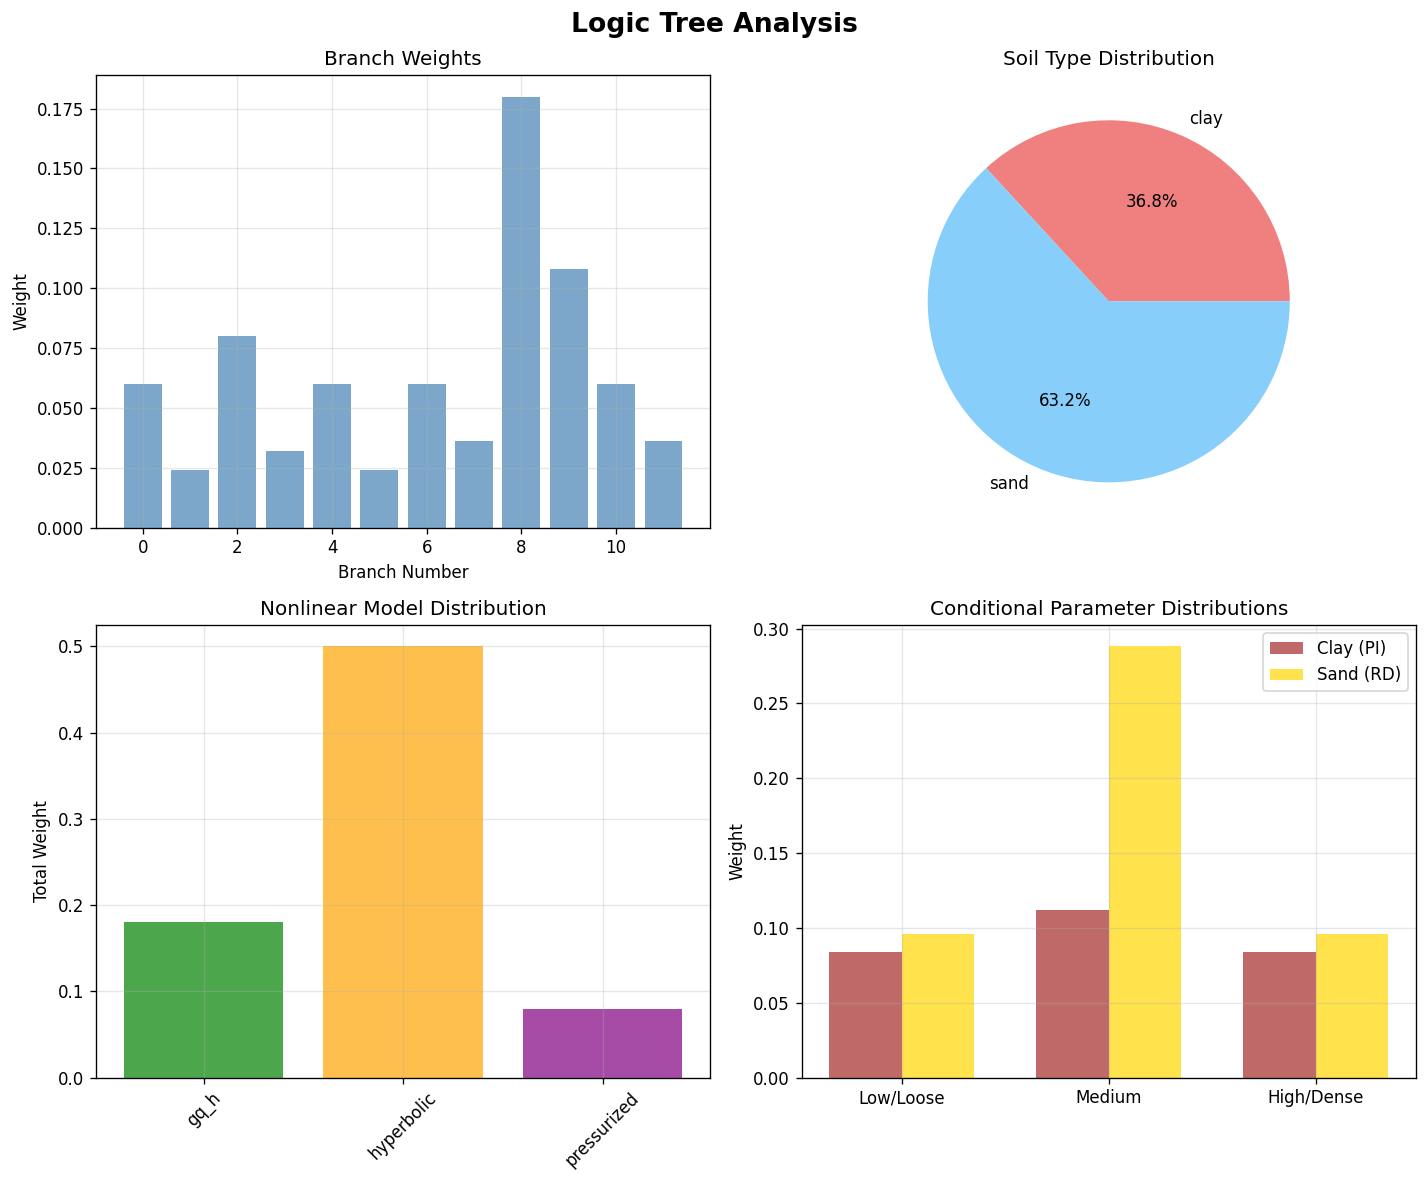

In [ ]:
# Create visualization of branch weights and parameter distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Logic Tree Analysis", fontsize=16, fontweight="bold")

# Branch weights distribution
axes[0, 0].bar(range(len(df)), df["weight"], alpha=0.7, color="steelblue")
axes[0, 0].set_xlabel("Branch Number")
axes[0, 0].set_ylabel("Weight")
axes[0, 0].set_title("Branch Weights")
axes[0, 0].grid(True, alpha=0.3)

# Soil type distribution
soil_weights = df.groupby("soil_type")["weight"].sum()
axes[0, 1].pie(
    soil_weights.values,
    labels=soil_weights.index,
    autopct="%1.1f%%",
    colors=["lightcoral", "lightskyblue"],
)
axes[0, 1].set_title("Soil Type Distribution")

# Nonlinear model distribution
model_weights = df.groupby("nonlinear_model")["weight"].sum()
bars = axes[1, 0].bar(
    model_weights.index,
    model_weights.values,
    color=["green", "orange", "purple"],
    alpha=0.7,
)
axes[1, 0].set_ylabel("Total Weight")
axes[1, 0].set_title("Nonlinear Model Distribution")
axes[1, 0].tick_params(axis="x", rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Conditional distributions
clay_data = df[df["soil_type"] == "clay"]
sand_data = df[df["soil_type"] == "sand"]

x_pos = np.arange(3)
clay_pi = (
    clay_data.groupby("plasticity_index")["weight"]
    .sum()
    .reindex(["low", "medium", "high"], fill_value=0)
)
sand_rd = (
    sand_data.groupby("relative_density")["weight"]
    .sum()
    .reindex(["loose", "medium", "dense"], fill_value=0)
)

width = 0.35
axes[1, 1].bar(
    x_pos - width / 2,
    clay_pi.values,
    width,
    label="Clay (PI)",
    alpha=0.7,
    color="brown",
)
axes[1, 1].bar(
    x_pos + width / 2, sand_rd.values, width, label="Sand (RD)", alpha=0.7, color="gold"
)
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(["Low/Loose", "Medium", "High/Dense"])
axes[1, 1].set_ylabel("Weight")
axes[1, 1].set_title("Conditional Parameter Distributions")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Miller-Rice Integration Points

PyStrata includes predefined integration points based on Miller and Rice (1983) for efficient numerical integration.

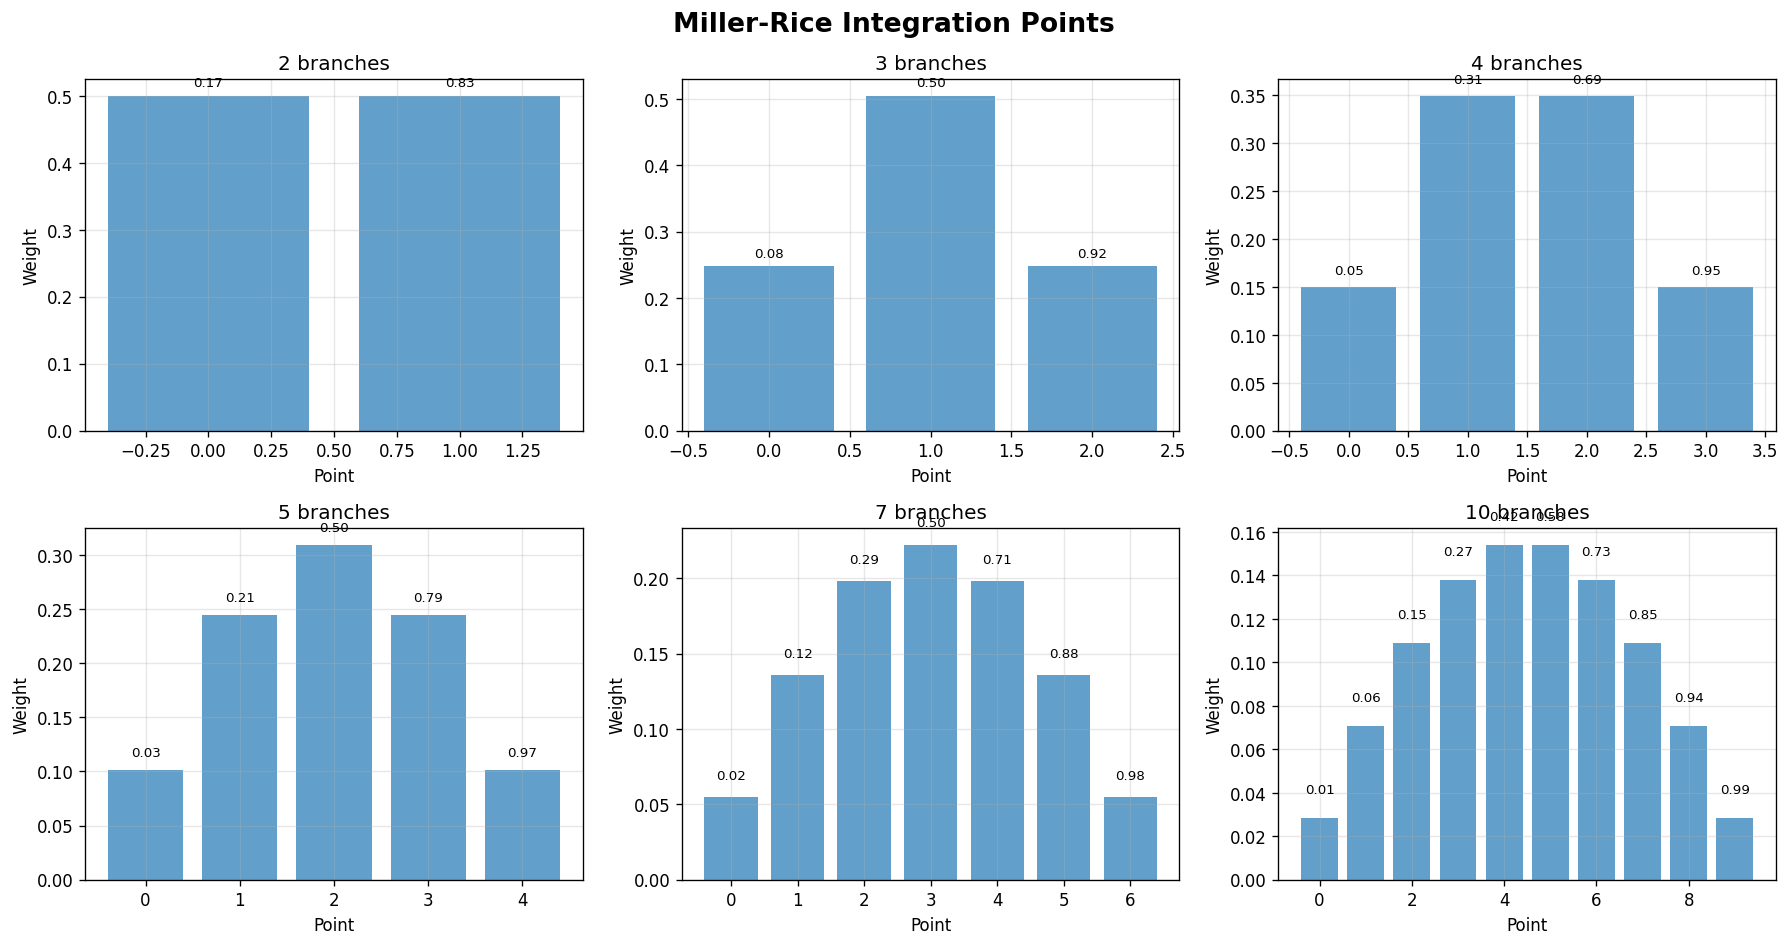

Miller-Rice integration points:

3 points:
  Point 1: value=0.084669, weight=0.247614
  Point 2: value=0.500000, weight=0.504771
  Point 3: value=0.915331, weight=0.247614

5 points:
  Point 1: value=0.034893, weight=0.101080
  Point 2: value=0.211702, weight=0.244290
  Point 3: value=0.500000, weight=0.309260
  Point 4: value=0.788298, weight=0.244290
  Point 5: value=0.965107, weight=0.101080

7 points:
  Point 1: value=0.019106, weight=0.054866
  Point 2: value=0.115498, weight=0.135893
  Point 3: value=0.285336, weight=0.198097
  Point 4: value=0.500000, weight=0.222288
  Point 5: value=0.714664, weight=0.198097
  Point 6: value=0.884502, weight=0.135893
  Point 7: value=0.980894, weight=0.054866


In [ ]:
# Create Miller-Rice nodes for different numbers of branches
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
fig.suptitle("Miller-Rice Integration Points", fontsize=16, fontweight="bold")

branches_list = [2, 3, 4, 5, 7, 10]
for i, n_branches in enumerate(branches_list):
    row = i // 3
    col = i % 3

    node = Node.from_miller_rice(f"param_{n_branches}", n_branches)

    values = [alt.value for alt in node.alts]
    weights = [alt.weight for alt in node.alts]

    axes[row, col].bar(range(len(values)), weights, alpha=0.7)
    axes[row, col].set_title(f"{n_branches} branches")
    axes[row, col].set_xlabel("Point")
    axes[row, col].set_ylabel("Weight")
    axes[row, col].grid(True, alpha=0.3)

    # Add value labels
    for j, (val, wt) in enumerate(zip(values, weights)):
        axes[row, col].text(
            j, wt + 0.01, f"{val:.2f}", ha="center", va="bottom", fontsize=8
        )

plt.tight_layout()
plt.show()

# Print the actual values and weights
print("Miller-Rice integration points:")
for n_branches in [3, 5, 7]:
    node = Node.from_miller_rice(f"param_{n_branches}", n_branches)
    print(f"\n{n_branches} points:")
    for i, alt in enumerate(node.alts):
        print(f"  Point {i + 1}: value={alt.value:.6f}, weight={alt.weight:.6f}")

## 6. Application to Site Response Analysis

Demonstrate how to use logic trees with actual site response calculations.

In [ ]:
# Create a basic site profile
def create_site_profile(vs_factor=1.0, damping_model="darendeli"):
    """Create a site profile with variable parameters."""

    # Define base soil properties
    layers = [
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(
                name="Clay",
                unit_wt=18.5 * 9.81,
                plas_index=20,
                stress_mean=(101.3 * 0.5),
            )
            if damping_model == "darendeli"
            else pystrata.site.WangSoilType(
                name="Clay",
                unit_wt=18.5 * 9.81,
                stress_mean=(101.3 * 0.5),
                soil_group="clayey_soil",
            ),
            thickness=10,
            shear_vel=300 * vs_factor,
        ),
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(
                name="Sand", unit_wt=19.0 * 9.81, plas_index=0, stress_mean=(101.3 * 1)
            )
            if damping_model == "darendeli"
            else pystrata.site.WangSoilType(
                name="Sand",
                unit_wt=19.0 * 9.81,
                stress_mean=(101.3 * 1),
                soil_group="clean_sand_and_gravel",
            ),
            thickness=20,
            shear_vel=500 * vs_factor,
        ),
        # Bedrock
        pystrata.site.Layer(
            pystrata.site.SoilType(name="Rock", unit_wt=24.0 * 9.81, damping=0.01),
            thickness=0,
            shear_vel=800,
        ),
    ]

    return pystrata.site.Profile(layers)


# Test the function
test_profile = create_site_profile()
print(f"Created profile with {len(test_profile)} layers")
for i, layer in enumerate(test_profile):
    print(
        f"Layer {i + 1}: {layer.soil_type.name}, Vs={layer.shear_vel:.0f} m/s, h={layer.thickness:.1f} m"
    )

Created profile with 3 layers
Layer 1: Clay, Vs=300 m/s, h=10.0 m
Layer 2: Sand, Vs=500 m/s, h=20.0 m
Layer 3: Rock, Vs=800 m/s, h=0.0 m


In [ ]:
# Create a simple input motion
motion = pystrata.motion.SourceTheoryRvtMotion(magnitude=6.5, distance=20, region="wna")

# Define a logic tree for site response uncertainty
site_response_tree = LogicTree(
    [
        Node(
            "vs_factor",
            [
                Alternative(0.8, weight=0.2),
                Alternative(1.0, weight=0.6),
                Alternative(1.2, weight=0.2),
            ],
        ),
        Node(
            "damping_model",
            [
                Alternative("darendeli", weight=0.7),
                Alternative("wang", weight=0.3),
            ],
        ),
    ]
)

# Run site response calculation
calc = pystrata.propagation.EquivalentLinearCalculator()

# Output at surface
outputs = pystrata.output.OutputCollection(
    [
        pystrata.output.ResponseSpectrumOutput(
            # Frequencies for response spectrum
            freqs=np.logspace(-1, 2, 91),
            location=pystrata.output.OutputLocation("outcrop", depth=0),
            osc_damping=0.05,
        ),
    ]
)

print("Computing site response for each logic tree branch...")
for i, branch in enumerate(site_response_tree):
    vs_factor = branch.value("vs_factor")
    damping_model = branch.value("damping_model")
    print(
        f"  Branch {i + 1}: vs_factor={vs_factor:.1f}, damping={damping_model}, weight={branch.weight:.1f}"
    )

    # Create profile for this branch
    profile = create_site_profile(vs_factor, damping_model).auto_discretize()

    calc(motion, profile, profile.location("outcrop", index=-1))
    outputs(calc, name=branch)

Computing site response for each logic tree branch...
  Branch 1: vs_factor=0.8, damping=darendeli, weight=0.1
  Branch 2: vs_factor=0.8, damping=wang, weight=0.1
  Branch 3: vs_factor=1.0, damping=darendeli, weight=0.4
  Branch 4: vs_factor=1.0, damping=wang, weight=0.2
  Branch 5: vs_factor=1.2, damping=darendeli, weight=0.1
  Branch 6: vs_factor=1.2, damping=wang, weight=0.1


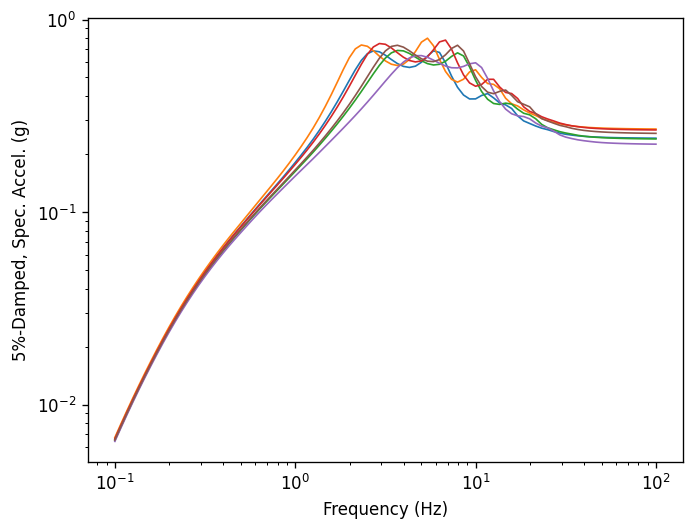

In [ ]:
ax = outputs[0].plot()
# Remove legend
ax.legend().set_visible(False)

## 8. Loading Logic Trees from JSON

Logic trees can be saved and loaded from JSON files for reproducibility and sharing.

In [ ]:
# Create a complex logic tree definition
logic_tree_definition = [
    {
        "name": "site_classification",
        "alts": [
            {"value": "C", "weight": 0.3, "params": {"vs30_range": [360, 760]}},
            {"value": "D", "weight": 0.6, "params": {"vs30_range": [180, 360]}},
            {"value": "E", "weight": 0.1, "params": {"vs30_range": [0, 180]}},
        ],
    },
    {
        "name": "kappa",
        "alts": [
            {"value": 0.02, "weight": 0.2, "requires": {"site_classification": "C"}},
            {"value": 0.03, "weight": 0.6, "requires": {"site_classification": "C"}},
            {"value": 0.04, "weight": 0.2, "requires": {"site_classification": "C"}},
            {"value": 0.03, "weight": 0.2, "requires": {"site_classification": "D"}},
            {"value": 0.04, "weight": 0.6, "requires": {"site_classification": "D"}},
            {"value": 0.05, "weight": 0.2, "requires": {"site_classification": "D"}},
            {"value": 0.05, "weight": 0.4, "requires": {"site_classification": "E"}},
            {"value": 0.06, "weight": 0.6, "requires": {"site_classification": "E"}},
        ],
    },
    {
        "name": "randomization_method",
        "alts": [
            {"value": "monte_carlo", "weight": 0.4, "params": {"n_realizations": 1000}},
            {
                "value": "latin_hypercube",
                "weight": 0.4,
                "params": {"n_realizations": 100},
            },
            {"value": "deterministic", "weight": 0.2, "params": {"n_realizations": 1}},
        ],
    },
]

# Save to JSON file
json_filename = "site_response_logic_tree.json"
with open(json_filename, "w") as f:
    json.dump(logic_tree_definition, f, indent=2)

print(f"Saved logic tree definition to {json_filename}")

# Load from JSON
loaded_tree = LogicTree.from_json(json_filename)
print(f"\nLoaded logic tree with {len(list(loaded_tree))} valid branches")

# Display the loaded tree structure
print("\nBranches from JSON logic tree:")
for i, branch in enumerate(loaded_tree):
    if i < 10:  # Show first 10 branches
        branch_info = {
            "site": branch.value("site_classification"),
            "kappa": branch.value("kappa"),
            "method": branch.value("randomization_method"),
            "weight": branch.weight,
        }
        print(f"  {i + 1:2d}: {branch_info}")
    elif i == 10:
        print("  ... (remaining branches omitted)")
        break

# Show JSON content
print(f"\nJSON file content:")
with open(json_filename, "r") as f:
    content = f.read()
    print(content[:500] + "..." if len(content) > 500 else content)

Saved logic tree definition to site_response_logic_tree.json

Loaded logic tree with 24 valid branches

Branches from JSON logic tree:
   1: {'site': 'C', 'kappa': 0.02, 'method': 'monte_carlo', 'weight': np.float64(0.024)}
   2: {'site': 'C', 'kappa': 0.02, 'method': 'latin_hypercube', 'weight': np.float64(0.024)}
   3: {'site': 'C', 'kappa': 0.02, 'method': 'deterministic', 'weight': np.float64(0.012)}
   4: {'site': 'C', 'kappa': 0.03, 'method': 'monte_carlo', 'weight': np.float64(0.072)}
   5: {'site': 'C', 'kappa': 0.03, 'method': 'latin_hypercube', 'weight': np.float64(0.072)}
   6: {'site': 'C', 'kappa': 0.03, 'method': 'deterministic', 'weight': np.float64(0.036)}
   7: {'site': 'C', 'kappa': 0.04, 'method': 'monte_carlo', 'weight': np.float64(0.024)}
   8: {'site': 'C', 'kappa': 0.04, 'method': 'latin_hypercube', 'weight': np.float64(0.024)}
   9: {'site': 'C', 'kappa': 0.04, 'method': 'deterministic', 'weight': np.float64(0.012)}
  10: {'site': 'C', 'kappa': 0.03, 'method': '